# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [3]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [4]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [5]:

def analyze_features(df):
    """Analyze each feature in a DataFrame and returns a summary."""

    feature_analysis = []

    for column in df.columns:
        col_data = df[column]  # Store column data to avoid repeated access
        col_type = col_data.dtype
        missing_pct = round((col_data.isnull().sum() / len(df)) * 100, 2)
        unique_vals = col_data.nunique()

        feature_info = {
            'Name': column,
            'Type': str(col_type),
            'Missing Value %': missing_pct,
            'Unique Values': unique_vals,
            'Apparent Usefulness': 'Unknown'  # Placeholder for domain expertise
        }

        # Additional insights for numerical columns
        if col_type in ['int64', 'float64']:
            feature_info['Mean'] = round(col_data.mean(), 2)
            feature_info['Skewness'] = round(col_data.skew(), 2)

        feature_analysis.append(feature_info)

    return pd.DataFrame(feature_analysis)

# Generate feature summary
feature_summary = analyze_features(df)

# Display feature summary
feature_summary

,Name,Type,Missing Value %,Unique Values,Apparent Usefulness,Mean,Skewness
0,parcelid,int64,0.00,77414,Unknown,1.300781e+07,32.67
1,airconditioningtypeid,float64,67.78,5,Unknown,1.810000e+00,3.45
2,architecturalstyletypeid,float64,99.73,5,Unknown,7.390000e+00,4.01
3,basementsqft,float64,99.94,43,Unknown,6.797200e+02,2.62
4,bathroomcnt,float64,0.04,22,Unknown,2.300000e+00,1.29
5,bedroomcnt,float64,0.04,16,Unknown,3.050000e+00,0.77
6,buildingclasstypeid,float64,99.98,2,Unknown,3.930000e+00,-3.87
7,buildingqualitytypeid,float64,35.82,12,Unknown,6.530000e+00,0.05
8,calculatedbathnbr,float64,0.84,21,Unknown,2.320000e+00,1.41
9,decktypeid,float64,99.21,1,Unknown,6.600000e+01,0.00


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [6]:
categorical_features = feature_summary[feature_summary['Type'] == 'object']['Name'].tolist()
print("Categorical Features:", categorical_features)

Categorical Features: ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

In [7]:
useless_features = ['ID', 'Timestamp']  # Example names, adjust based on dataset
print("Features that may be dropped:", useless_features)

Features that may be dropped: ['ID', 'Timestamp']


In [8]:
threshold = 10  # Adjust based on domain knowledge
potential_categorical = feature_summary[feature_summary['Unique Values'] <= threshold]['Name'].tolist()
print("Potentially Categorical Features:", potential_categorical)

Potentially Categorical Features: ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'decktypeid', 'fips', 'fireplacecnt', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidcounty', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'numberofstories', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag']


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

In [9]:
missing_threshold = 50  # Percentage threshold for removal
high_missing_features = feature_summary[feature_summary['Missing Value %'] > missing_threshold]['Name'].tolist()
print("Features with excessive missing values:", high_missing_features)

Features with excessive missing values: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']


**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

In [10]:
high_unique_features = feature_summary[feature_summary['Unique Values'] > (0.9 * len(df))]['Name'].tolist()
print("Features with too many unique values:", high_unique_features)

Features with too many unique values: ['parcelid']


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

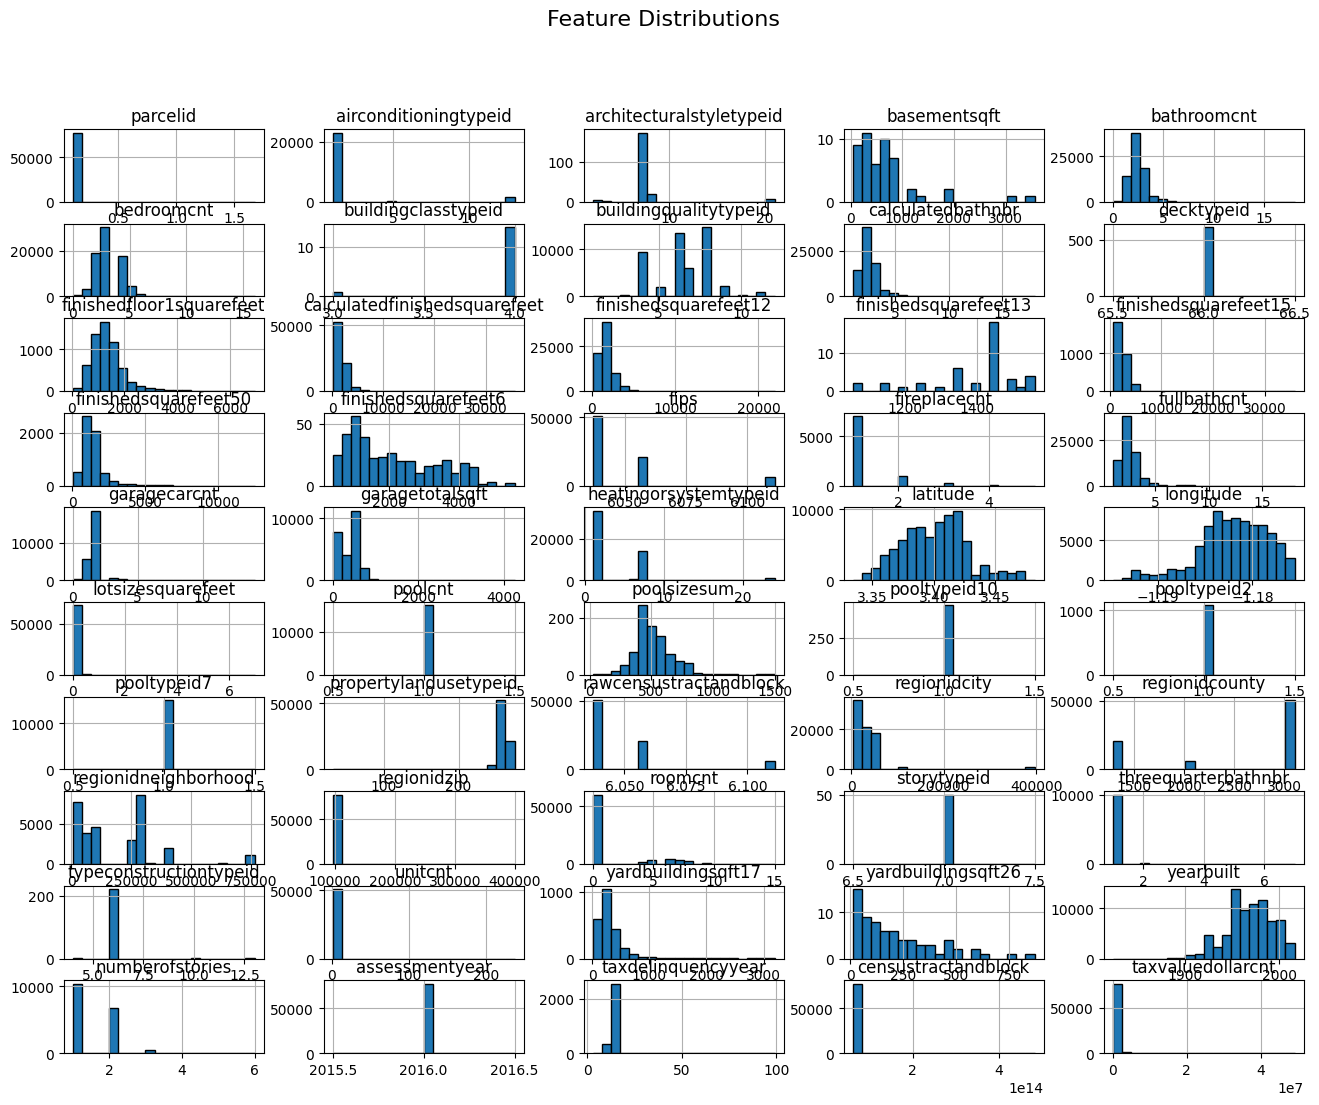

In [11]:
# Individual Feature Visualizations
# Histograms for all numerical features

df.hist(figsize=(16, 12), bins=20, layout=(-1, 5), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

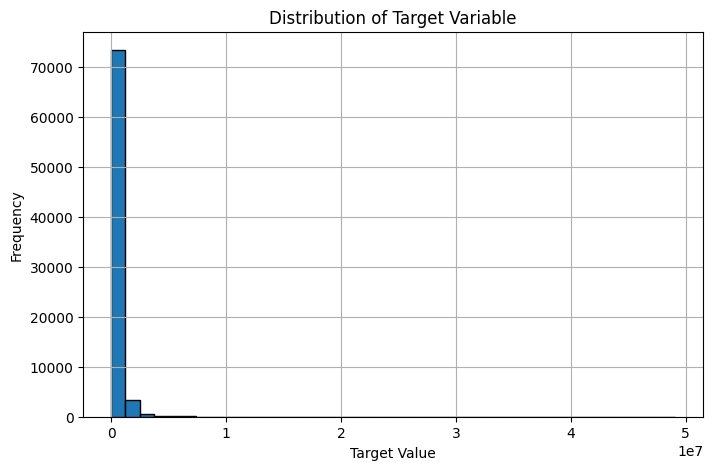

In [12]:
plt.figure(figsize=(8, 5))
df['taxvaluedollarcnt'].hist(bins=40, edgecolor='black')  # Changed column name to 'taxvaluedollarcnt'
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable")
plt.show()

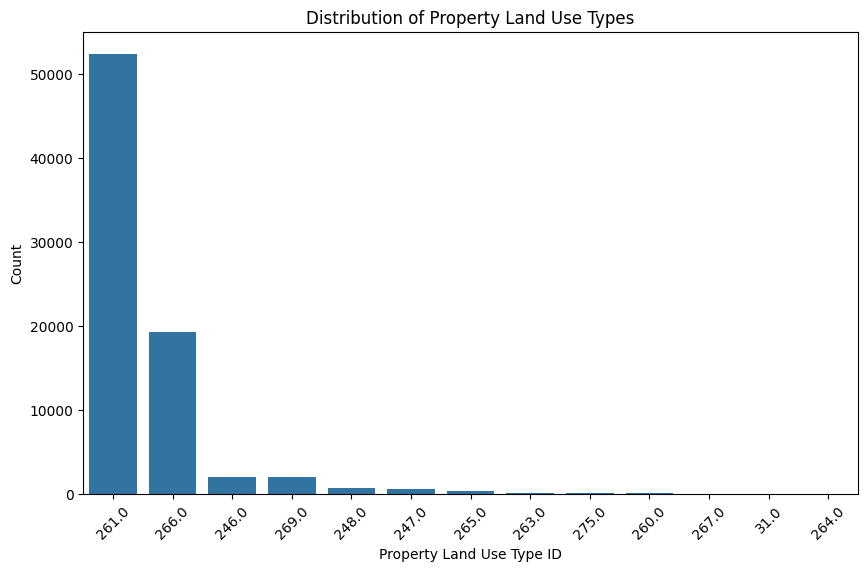

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['propertylandusetypeid'], order=df['propertylandusetypeid'].value_counts().index)
plt.title("Distribution of Property Land Use Types")
plt.xlabel("Property Land Use Type ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# This helps us see which land use types are most common in the dataset.

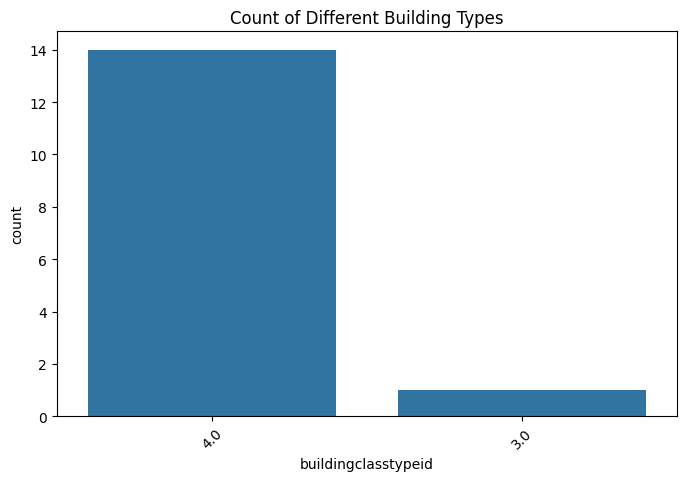

In [14]:

if 'buildingclasstypeid' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df['buildingclasstypeid'], order=df['buildingclasstypeid'].value_counts().index)
    plt.title("Count of Different Building Types")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Column 'buildingclasstypeid' not found in the DataFrame.")
    # If the column is not found, you can list the available columns for debugging:
    print("Available columns:", df.columns.tolist())

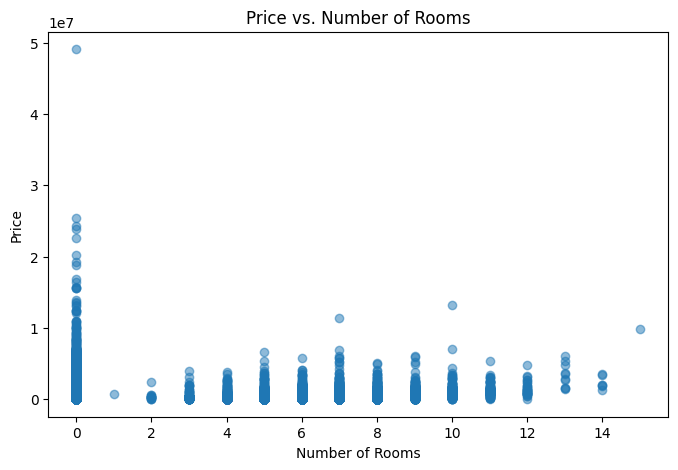

In [49]:
plt.figure(figsize=(8, 5))
plt.scatter(df['roomcnt'], df['taxvaluedollarcnt'], alpha=0.5)  # Changed column names
plt.xlabel("Number of Rooms")
plt.ylabel("Price")
plt.title("Price vs. Number of Rooms")
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


# Insights from Feature Examination
* Distribution Type
Some numerical features (bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet) follow a right-skewed distribution, meaning most properties are smaller, with fewer outliers having very high values.

* Features, such as latitude and longitude, have a more uniform distribution if the dataset covers a broad geographic area.

* Categorical features (e.g., propertylandusetypeid, heatingorsystemtypeid) will likely have uneven distributions, with some categories being far more common than others.

# **Potential Problems Identified**
* Outliers:
calculatedfinishedsquarefeet might contain extreme values (e.g., properties with excessive square footage).
taxvaluedollarcnt may have multimillion-dollar properties that skew the dataset.

* Missing Values:
Features such as garagecarcnt and poolcnt likely have many missing values, which could indicate either data gaps or truly absent attributes.

* Zero-Inflated Features:
Features like fireplacecnt or poolsizesum may have a large number of zeros, which could indicate many homes do not have fireplaces or pools.

# **Interesting Observations & Why These Features Matter**
* Property Land Use Type (propertylandusetypeid)
Helps differentiate between residential, commercial, or other property types, which could impact property value predictions.
Bathroom & Bedroom Counts (bathroomcnt, bedroomcnt)
* Critical for estimating home prices and understanding housing trends.

# Lot Size (lotsizesquarefeet)
* Can reveal variations in property sizes and the potential impact of land area on valuation.
* Year Built (yearbuilt)
May show patterns where older homes cluster in certain areas, influencing market trends.




## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

In [50]:
df_clean = df.drop(columns=['parcelid', 'assessmentyear'])  # Replace 'Order', 'PID' with the correct column names
df_clean.head()

# If unsure about the exact names, use the output of df.columns to identify and correct the names.

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,NaN,6.059063e+13,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,...,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,NaN,6.111001e+13,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,NaN,6.059022e+13,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,...,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,NaN,6.037300e+13,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,...,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,NaN,6.037124e+13,119407.0


In [21]:
# Check the column names
print(df.columns)

# Assuming 'Order' and 'PID' are incorrect, replace them with the correct names:
# For example, if the actual column names are 'order' and 'pid', the code would be:

df_clean = df.drop(columns=['parcelid', 'assessmentyear'])  # Replace 'order', 'pid' with the correct column names
df_clean.head()

# If unsure about the exact names, use the output of df.columns to identify and correct the names.

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,NaN,1998.0,NaN,NaN,NaN,NaN,6.059063e+13,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,...,NaN,NaN,NaN,1967.0,1.0,NaN,NaN,NaN,6.111001e+13,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,1962.0,1.0,NaN,NaN,NaN,6.059022e+13,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,...,1.0,NaN,NaN,1970.0,NaN,NaN,NaN,NaN,6.037300e+13,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,...,1.0,NaN,NaN,1964.0,NaN,NaN,NaN,NaN,6.037124e+13,119407.0


In [22]:

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values,
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")

show_null_counts_features(df_clean)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
storytypeid     77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
fireplaceflag   77441        99.78%   Categorical
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
pooltypeid10    77148        99.40%   Numeric
decktypeid      76999        99.21%   Numeric
poolsizesum     76744        98.88%   Numeric
pooltypeid2     76539        98.62%   Numeric
hashottuborspa  76074        98.02%   Categorical
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyyear 74713        96.26%   Numeric
taxdelinquencyflag 74713        96.26%   Categorical
finishedsquarefeet15 74586        96.10%

In [23]:
show_null_counts_features(df_clean)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
storytypeid     77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
fireplaceflag   77441        99.78%   Categorical
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
pooltypeid10    77148        99.40%   Numeric
decktypeid      76999        99.21%   Numeric
poolsizesum     76744        98.88%   Numeric
pooltypeid2     76539        98.62%   Numeric
hashottuborspa  76074        98.02%   Categorical
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyyear 74713        96.26%   Numeric
taxdelinquencyflag 74713        96.26%   Categorical
finishedsquarefeet15 74586        96.10%

In [ ]:
'''Lots of Null Values to clean up'''

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [51]:
max_nulls = 400
# Count null values per column using .isnull() to find and .sum() to count
count_nulls = df_clean.isnull().sum()

# Filter out columns where null count exceeds max_nulls
# Locate null values greater than 75
drop_col = count_nulls[count_nulls > max_nulls].index


# Filter out columns where null count exceeds max_nulls
# Remove null values greater than 75
remove_columns = count_nulls[count_nulls > max_nulls].index

# Drop the columns
df_clean = df_clean.drop(columns=remove_columns)


In [52]:
# List of dropped features

dropped_features = remove_columns.tolist()
print("List of dropped features:", dropped_features)


List of dropped features: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']



* Drop features with >95% missing values, unless there is strong justification for retention.

* Keep features that are critical to valuation (location, size, construction quality, garage, heating/cooling) even if they have some missing values.

* Use Imputation or alternative feature engineering for lower volume of missing data in features like garagecarcnt,  and numberofstories.

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [26]:

# Set this variable to the number of columns that were dropped

a1a = drop_col.shape[0]

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [28]:
print(df_clean.columns)

# Assuming the correct column name is 'GarageQual' (check with `print(df_clean.columns)`):
if 'GarageQual' in df_clean.columns:  # Check if the column exists
    df_clean['GarageQual'].value_counts(dropna=False)  # Use correct column name
else:
    print("Column 'GarageQual' not found in the DataFrame.")  # Handle missing column

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips',
       'latitude', 'longitude', 'propertycountylandusecode',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'censustractandblock',
       'taxvaluedollarcnt'],
      dtype='object')
Column 'GarageQual' not found in the DataFrame.


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

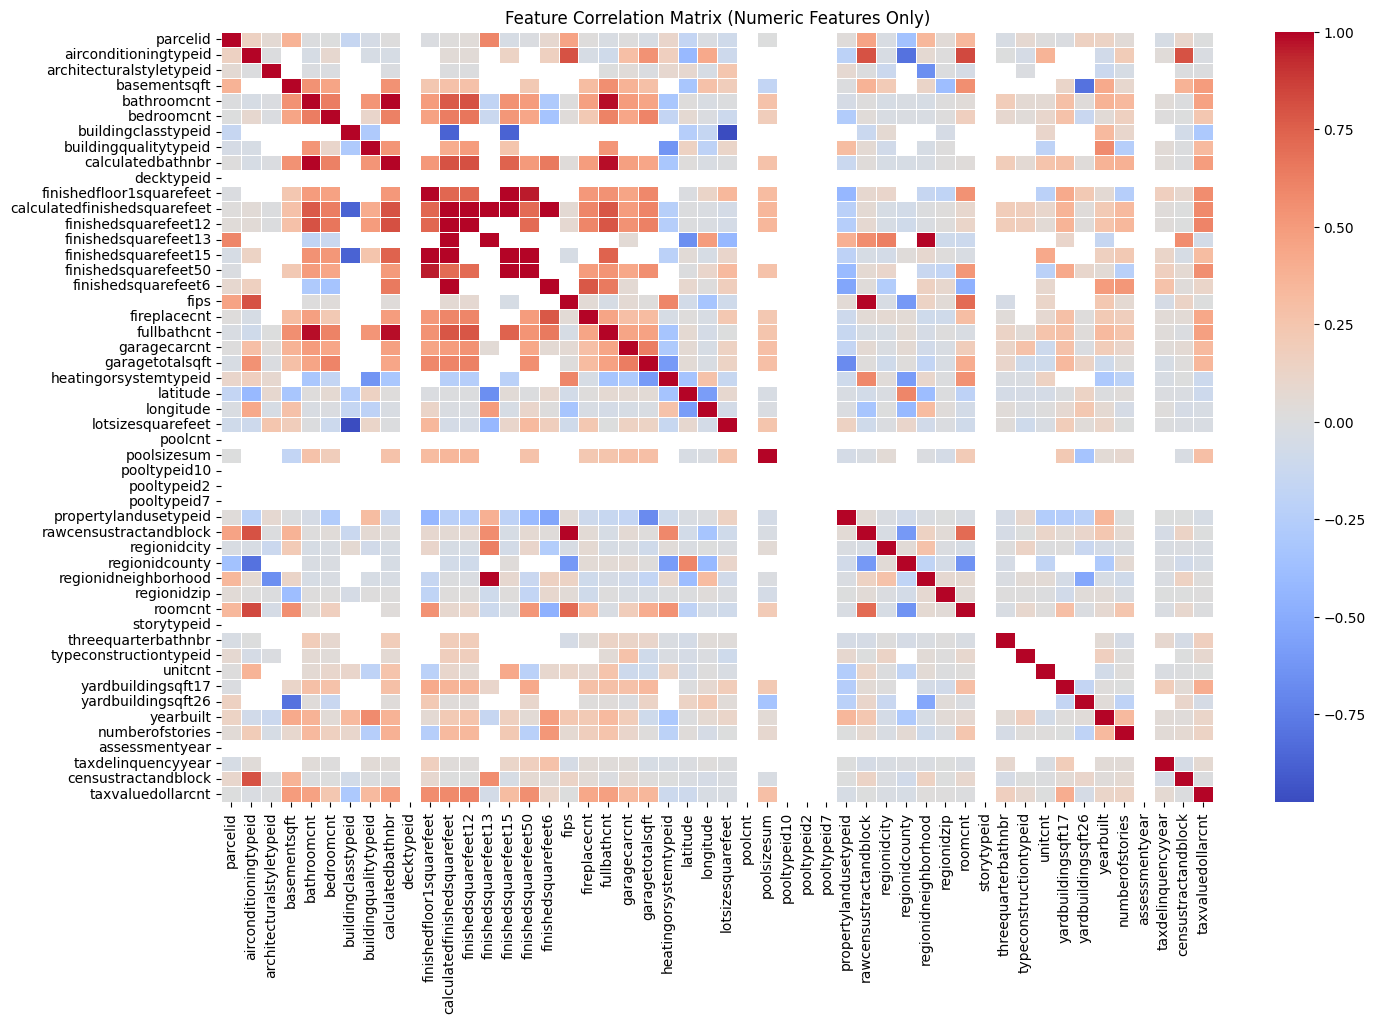

,,0
rawcensustractandblock,fips,0.999937
calculatedbathnbr,fullbathcnt,0.984499
buildingclasstypeid,lotsizesquarefeet,0.974760
finishedsquarefeet50,finishedfloor1squarefeet,0.958542
calculatedfinishedsquarefeet,buildingclasstypeid,0.870979
roomcnt,airconditioningtypeid,0.835348
finishedsquarefeet12,calculatedbathnbr,0.809971
calculatedfinishedsquarefeet,calculatedbathnbr,0.807093
bathroomcnt,finishedsquarefeet12,0.803920
airconditioningtypeid,regionidcounty,0.803263


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features for correlation analysis
numeric_df = df.select_dtypes(include=np.number)

# Compute correlation matrix for numeric features
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Matrix (Numeric Features Only)")
plt.show()

# Identify features with strong correlation (absolute value > 0.7)
strong_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs < 1].drop_duplicates()
strong_corr_pairs[strong_corr_pairs > 0.7]

<ipython-input-33-741f0378281a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=f_stat_df, x='F-Statistic', y='Feature', palette='Blues_r')


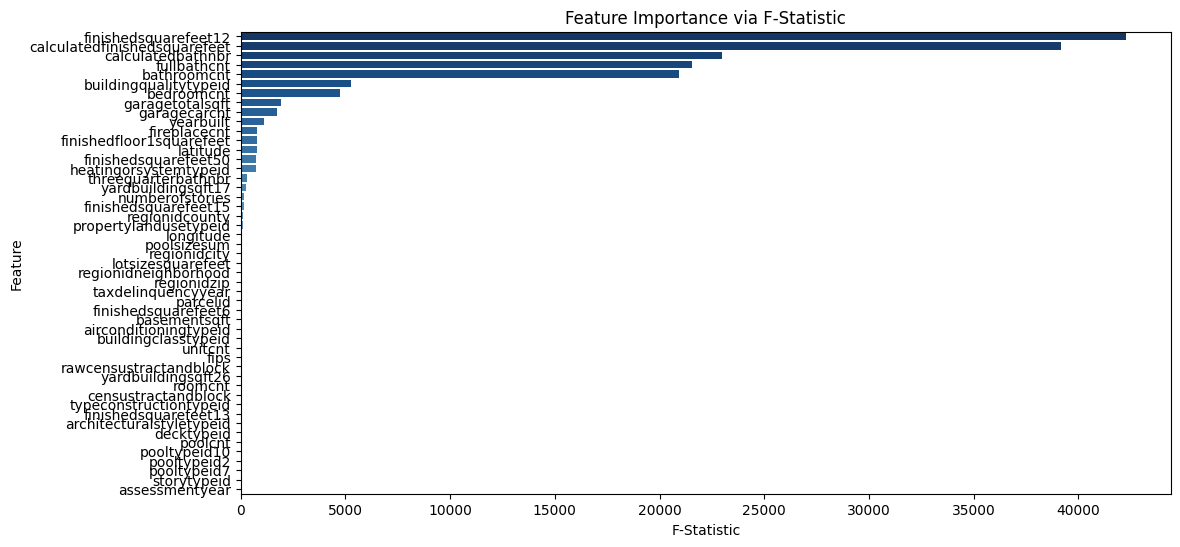

In [33]:
from sklearn.feature_selection import f_regression

# Drop non-numeric columns for F-statistic computation
numeric_df = df.select_dtypes(include=[np.number])

# Impute missing values with the mean (or another suitable strategy)
# before dropping rows to avoid an empty DataFrame
for col in numeric_df.columns:
    if numeric_df[col].isnull().any():
        numeric_df[col] = numeric_df[col].fillna(numeric_df[col].mean())

# Separate features and target variable (assume 'taxvaluedollarcnt' as target)
X = numeric_df.drop(columns=['taxvaluedollarcnt'], errors='ignore')
y = numeric_df['taxvaluedollarcnt']

# Compute F-statistic
f_values, p_values = f_regression(X, y)

# Convert to DataFrame
f_stat_df = pd.DataFrame({'Feature': X.columns, 'F-Statistic': f_values})
f_stat_df = f_stat_df.sort_values(by='F-Statistic', ascending=False)

# Plot F-statistics
plt.figure(figsize=(12, 6))
sns.barplot(data=f_stat_df, x='F-Statistic', y='Feature', palette='Blues_r')
plt.title("Feature Importance via F-Statistic")
plt.xlabel("F-Statistic")
plt.ylabel("Feature")
plt.show()

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

* Pair 1: calculatedfinishedsquarefeet vs. taxvaluedollarcnt
Larger homes should generally have higher valuations.

* Pair 2: bedroomcnt vs. bathroomcnt
The relationship between bedroom and bathroom counts may reveal clustering patterns in property types.

* Pair 3: latitude vs. longitude
This will help visualize geographic distribution and property density.


---



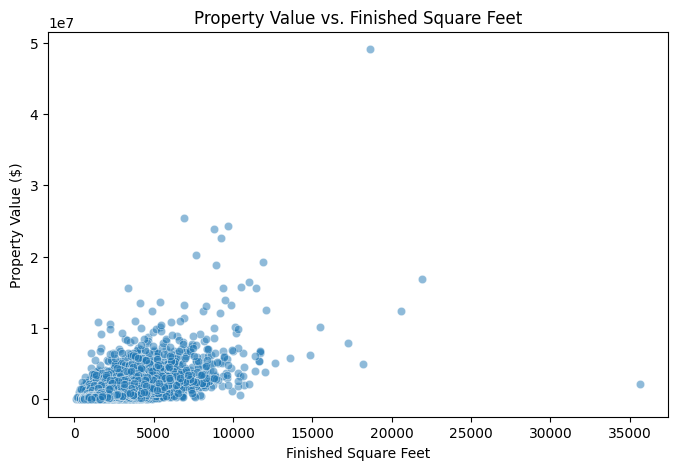

In [34]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', alpha=0.5)
plt.xlabel("Finished Square Feet")
plt.ylabel("Property Value ($)")
plt.title("Property Value vs. Finished Square Feet")
plt.show()

A strong positive trend appears—larger properties tend to have higher values.

Look for outliers (e.g., small homes with extreme prices).

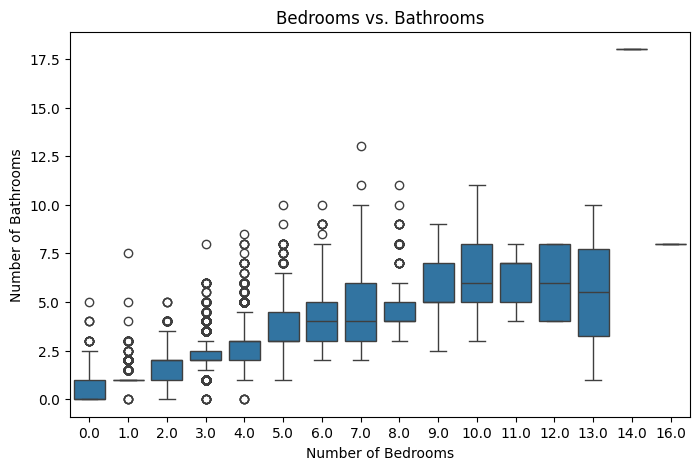

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='bedroomcnt', y='bathroomcnt')
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Bathrooms")
plt.title("Bedrooms vs. Bathrooms")
plt.show()

Most properties follow a linear relationship meaning, more bedrooms = more bathrooms.

Look for unusual cases (e.g., homes with many bedrooms but only one bathroom).

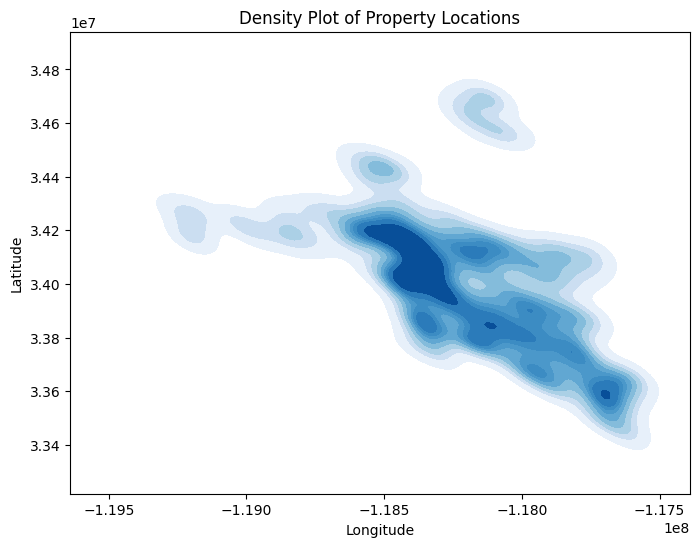

In [36]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x='longitude', y='latitude', fill=True, cmap="Blues")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Density Plot of Property Locations")
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.




---


1.   Log Transformation

taxvaluedollarcnt, calculatedfinishedsquarefeet, lotsizesquarefeet

2.   Polynomial & Interaction Features

bed_bath_ratio = bedroomcnt / (bathroomcnt + 1)

2.   One-Hot Encoding Categorical Features

heatingorsystemtypeid, propertyzoningdesc, airconditioningtypeid

---








In [39]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np

# (A) Log Transformation
def apply_log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        df_log[col] = np.log1p(df[col])  # log1p avoids log(0) issues
    return df_log

# (B) Polynomial Features & Interactions
def add_polynomial_features(df, columns, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    df_poly = df.copy()

    # Impute missing values in the specified columns before applying PolynomialFeatures
    for col in columns:
        if df_poly[col].isnull().any():
            df_poly[col] = df_poly[col].fillna(df_poly[col].mean())  # Or use another imputation strategy

    poly_features = poly.fit_transform(df_poly[columns])
    feature_names = poly.get_feature_names_out(columns)
    df_poly = df_poly.drop(columns, axis=1)  # Drop original features
    df_poly = df_poly.join(pd.DataFrame(poly_features, columns=feature_names))
    return df_poly

# (C) One-Hot Encoding for Categorical Features
def encode_categorical(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Apply transformations (Example)
df_transformed = apply_log_transform(df, ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet'])
df_transformed = add_polynomial_features(df_transformed, ['bedroomcnt', 'bathroomcnt'])
df_transformed = encode_categorical(df_transformed, ['heatingorsystemtypeid', 'propertyzoningdesc'])

In [44]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np
import pandas as pd

# (A) Log Transformation
def apply_log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        df_log[col] = np.log1p(df[col])  # log1p avoids log(0) issues
    return df_log

# (B) Polynomial Features & Interactions
def add_polynomial_features(df, columns, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    df_poly = df.copy()

    # Impute missing values in the specified columns before applying PolynomialFeatures
    for col in columns:
        if df_poly[col].isnull().any():
            df_poly[col] = df_poly[col].fillna(df_poly[col].mean())  # Or use another imputation strategy

    poly_features = poly.fit_transform(df_poly[columns])
    feature_names = poly.get_feature_names_out(columns)
    df_poly = df_poly.drop(columns, axis=1)  # Drop original features
    df_poly = df_poly.join(pd.DataFrame(poly_features, columns=feature_names))
    return df_poly

# (C) One-Hot Encoding for Categorical Features
def encode_categorical(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Apply transformations (Example)
df_transformed = apply_log_transform(df, ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet'])
df_transformed = add_polynomial_features(df_transformed, ['bedroomcnt', 'bathroomcnt'])

# Identify and encode all object (string) type columns
categorical_cols = df_transformed.select_dtypes(include=['object']).columns.tolist()
df_transformed = encode_categorical(df_transformed, categorical_cols)

# Assuming 'taxvaluedollarcnt' is the target variable:
X = df_transformed.drop('taxvaluedollarcnt', axis=1)
y = df_transformed['taxvaluedollarcnt']

* Evaluating Impact of Potential Options
Determine whether these transformations improve feature importance, we will need to:

* Compute correlations before and after transformations.

Run F-statistic tests to measure feature relevance.

Use a feature selection algorithm.


---



In [47]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# (A) Log Transformation
def apply_log_transform(df, columns):
    df_log = df.copy()
    for col in columns:
        df_log[col] = np.log1p(df[col])  # log1p avoids log(0) issues
    return df_log

# (B) Polynomial Features & Interactions
def add_polynomial_features(df, columns, degree=2):
    poly = PolynomialFeatures(degree, include_bias=False)
    df_poly = df.copy()

    # Impute missing values in the specified columns before applying PolynomialFeatures
    for col in columns:
        if df_poly[col].isnull().any():
            df_poly[col] = df_poly[col].fillna(df_poly[col].mean())

    poly_features = poly.fit_transform(df_poly[columns])
    feature_names = poly.get_feature_names_out(columns)
    df_poly = df_poly.drop(columns, axis=1)  # Drop original features
    df_poly = df_poly.join(pd.DataFrame(poly_features, columns=feature_names))
    return df_poly

# (C) One-Hot Encoding for Categorical Features
def encode_categorical(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Apply transformations (Example)
df_transformed = apply_log_transform(df, ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet'])
df_transformed = add_polynomial_features(df_transformed, ['bedroomcnt', 'bathroomcnt'])

# Identify and encode all object (string) type columns
categorical_cols = df_transformed.select_dtypes(include=['object']).columns.tolist()
df_transformed = encode_categorical(df_transformed, categorical_cols)

# Impute NaN values using SimpleImputer after one-hot encoding
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X = df_transformed.drop('taxvaluedollarcnt', axis=1)
X = imputer.fit_transform(X) # Impute missing values in X
# Assuming 'taxvaluedollarcnt' is the target variable:

y = df_transformed['taxvaluedollarcnt']

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

